In [1]:
#==================================================================
#TEMPORARY REFERENCE
#==================================================================

#Conversion from record to physical LineNums
#physicalLineNums.csv MUST be zero-indexed

##Conversion between the segline_config.txt to a measured mask
##Note that the last column positition NEEDS to match with the FOV width specified in sampleInfo.txt 
##i.e. if 7.5 was specified, but the segline_config.txt indicates a maximum position of 7.48, 
##there will be problems with the resulting alignment and reconstruction!

#measuredMask = np.zeros((finalDim))
#for lineData in np.loadtxt(sampleFolder+os.path.sep+'segline_config.txt', delimiter='\t'):
#    measuredMask[int(lineData[0]-1),int(round(((lineData[1]*1e3)/scanRate)*acqRate)):int(round(((lineData[2]*1e3)/scanRate)*acqRate))] = 1
#plt.imshow(measuredMask,cmap='gray', aspect='auto')
#plt.show()
#np.savetxt(sampleFolder+os.path.sep+'measuredMask.csv', measuredMask, delimiter=',', fmt='%d')

#If converting from a .csv file
#If Excel, copy data into a new csv file, as encoding from 'save as' causes errors
#measuredMask = np.zeros((finalDim))
#for lineData in np.loadtxt(sampleFolder+os.path.sep+'segline_config.csv', delimiter=','):
#    measuredMask[int(lineData[0]-1),int(round(((lineData[1]*1e3)/scanRate)*acqRate)):int(round(((lineData[2]*1e3)/scanRate)*acqRate))] = 1
#plt.imshow(measuredMask,cmap='gray', aspect='auto')
#plt.show()
#np.savetxt(sampleFolder+os.path.sep+'measuredMask.csv', measuredMask, delimiter=',', fmt='%d')
#==================================================================

In [2]:
#==================================================================
#GENERAL LIBRARY IMPORTS
#==================================================================

import glob
import matplotlib.pyplot as plt
import natsort
import numpy as np
import os
import shutil
import sys

from multiplierz.mzAPI import mzFile
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm

#==================================================================

In [4]:
#==================================================================
#SCRIPT CONFIGURATION
#==================================================================

#If the measurement times listed in the acquried MSI files do not start with 0 being at the left-side of the FOV
impOffset = True

#How many neighbors should be used in the reconstruction estimation
numNeighbors = 10

#==================================================================

In [5]:
#==================================================================
#METHOD DEFINITIONS
#==================================================================

def findNeighbors(measuredIdxs, unMeasuredIdxs):

    #Calculate knn
    neigh = NearestNeighbors(n_neighbors=numNeighbors).fit(measuredIdxs)
    neighborDistances, neighborIndices = neigh.kneighbors(unMeasuredIdxs)

    #Determine inverse distance weights
    unNormNeighborWeights = 1.0/np.square(neighborDistances)
    neighborWeights = unNormNeighborWeights/(np.sum(unNormNeighborWeights, axis=1))[:, np.newaxis]

    return neighborIndices, neighborWeights, neighborDistances

def computeRecon(inputImage, squareMeasuredIdxs, squareUnMeasuredIdxs, neighborIndices, neighborWeights):

    #Create a blank image for the reconstruction
    reconImage = np.zeros(inputImage.shape)
    
    #If 3d array, then perform all the reconstructions all at once
    if len(reconImage.shape) == 3:

        #Retreive measured values
        measuredValues = inputImage[:, squareMeasuredIdxs[:,0], squareMeasuredIdxs[:,1]]
        
        #Compute reconstruction values using IDW (inverse distance weighting)
        reconImage[:, squareUnMeasuredIdxs[:,0], squareUnMeasuredIdxs[:,1]] = np.sum(measuredValues[:, neighborIndices]*neighborWeights, axis=-1)

        #Combine measured values back into the reconstruction image
        reconImage[:, squareMeasuredIdxs[:,0], squareMeasuredIdxs[:,1]] = measuredValues
    else:
        
        #Retreive measured values
        measuredValues = inputImage[squareMeasuredIdxs[:,0], squareMeasuredIdxs[:,1]]
        
        #Compute reconstruction values using IDW (inverse distance weighting)
        reconImage[squareUnMeasuredIdxs[:,0], squareUnMeasuredIdxs[:,1]] = np.sum(measuredValues[neighborIndices]*neighborWeights, axis=1)

        #Combine measured values back into the reconstruction image
        reconImage[squareMeasuredIdxs[:,0], squareMeasuredIdxs[:,1]] = measuredValues

    return reconImage

#==================================================================

Samples:   0%|          | 0/1 [00:00<?, ?it/s]

Loading Files:   0%|          | 0/77 [00:00<?, ?it/s]

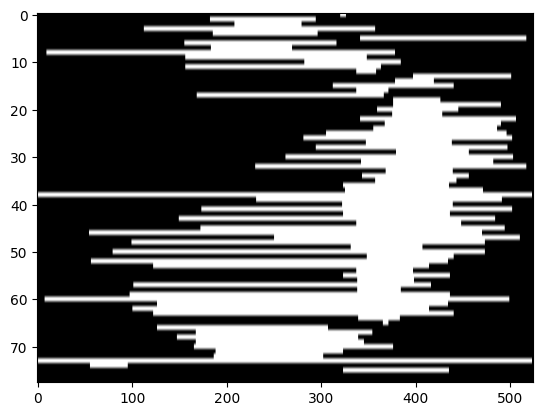

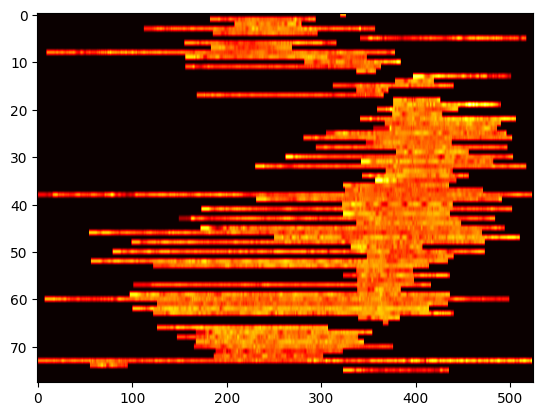

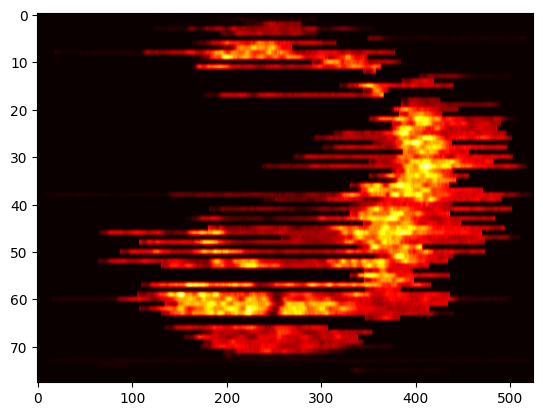

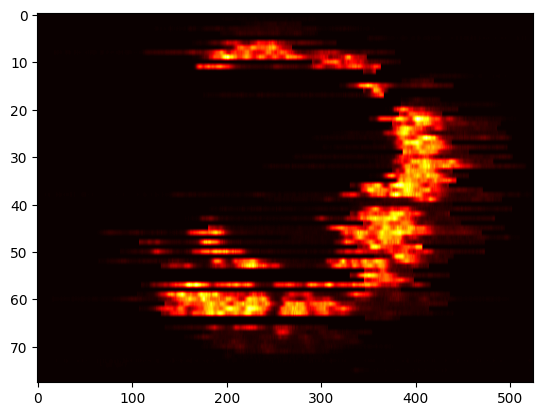

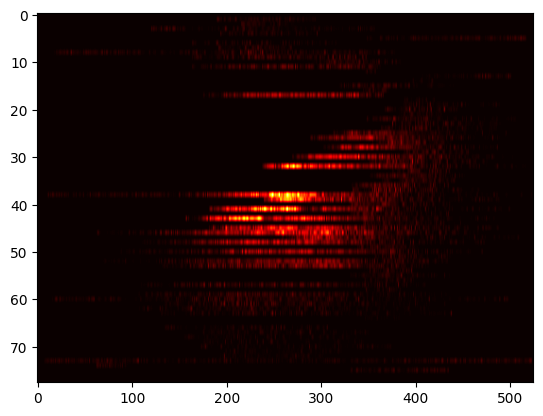

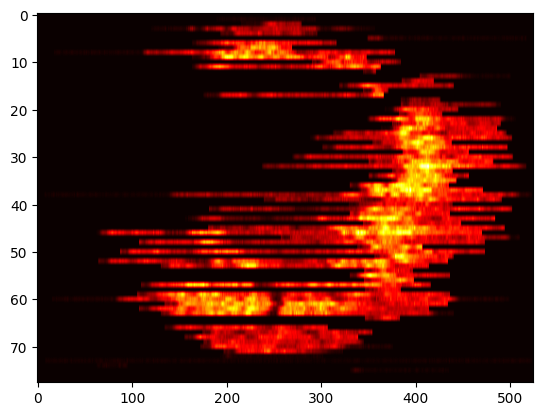

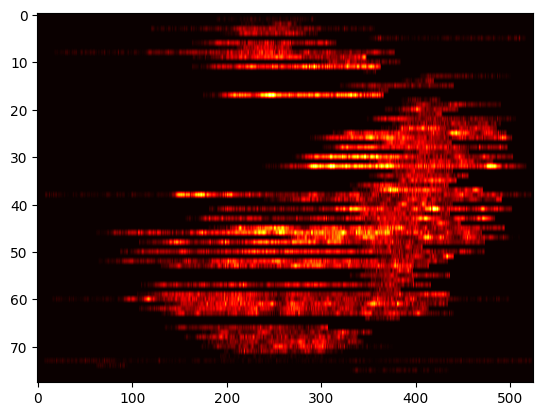

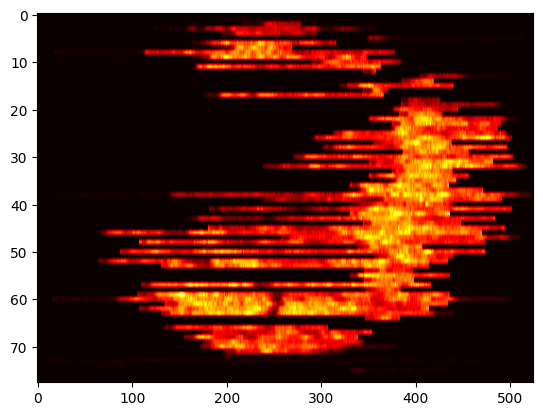

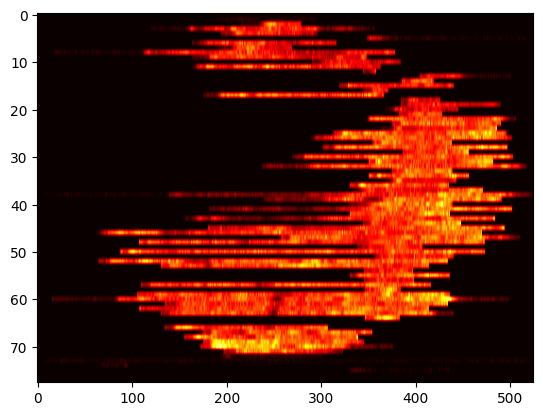

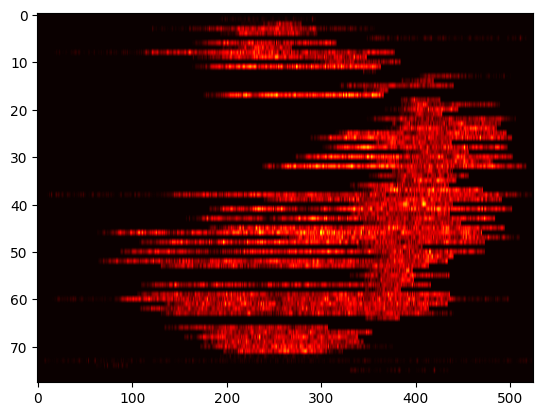

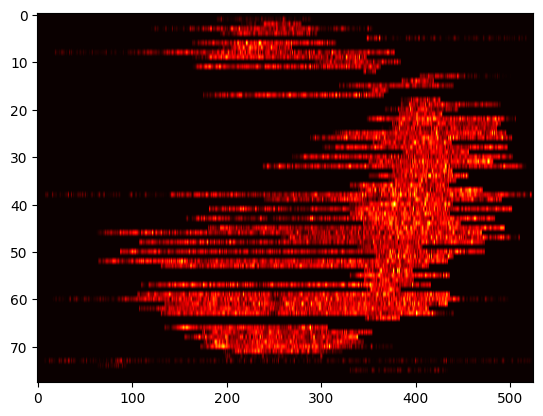

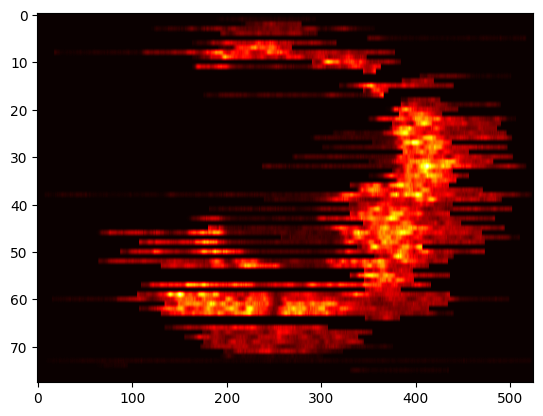

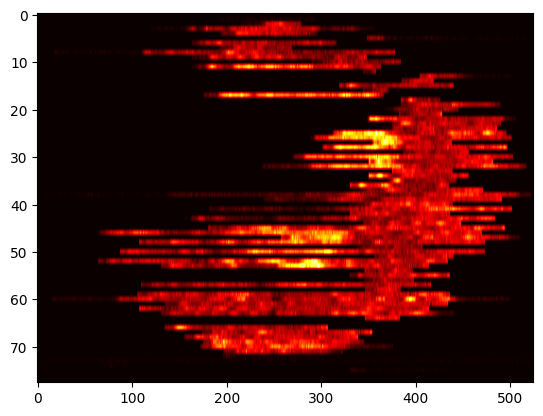

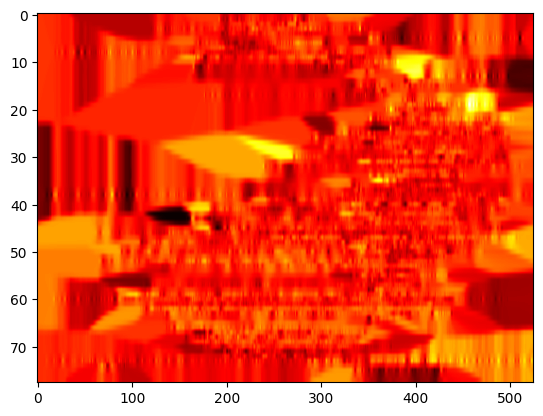

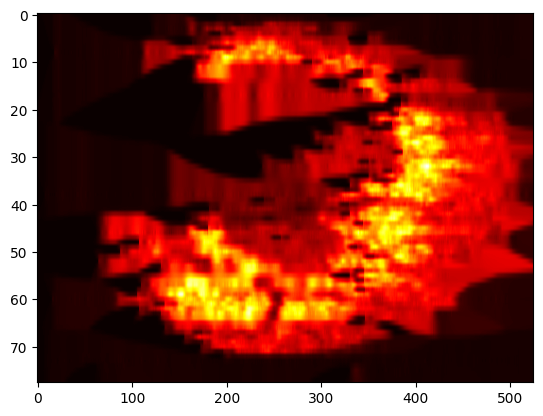

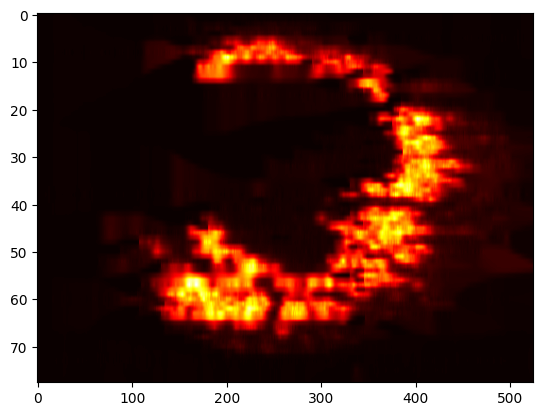

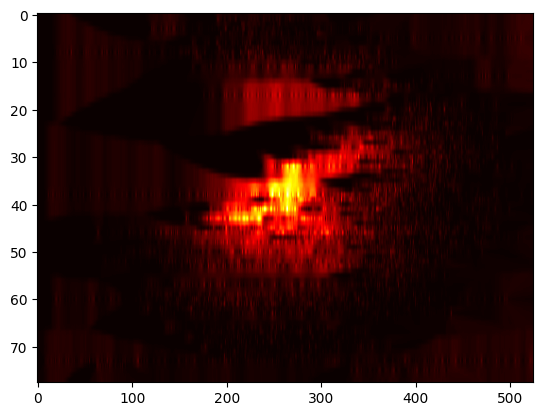

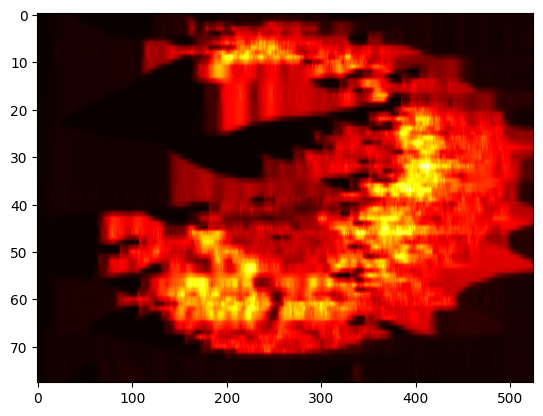

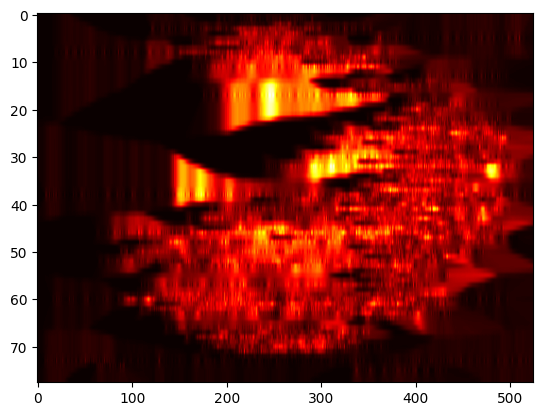

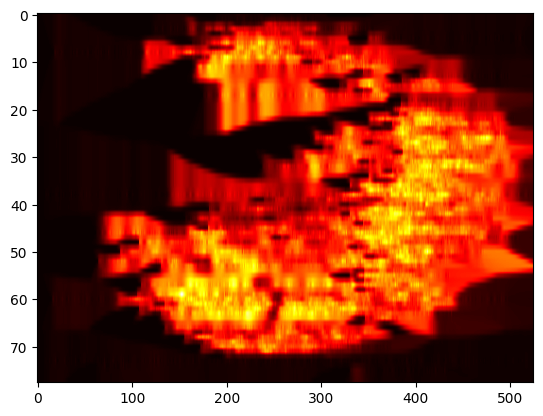

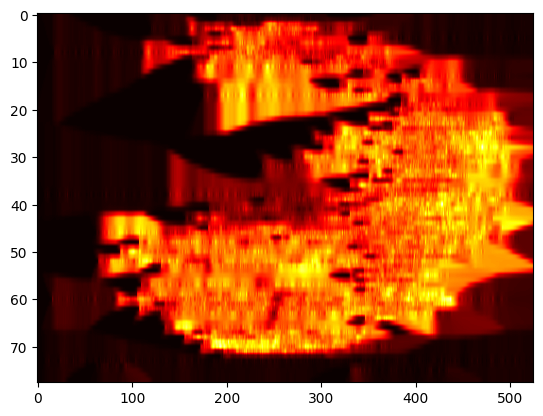

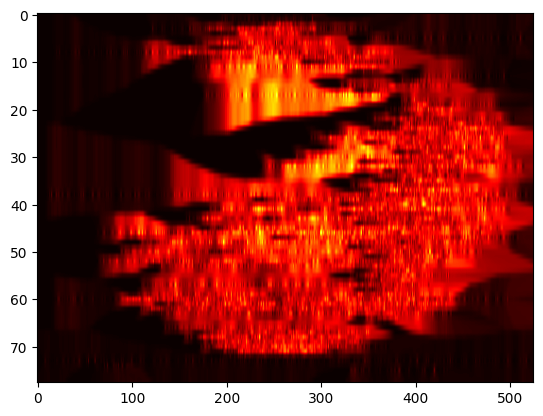

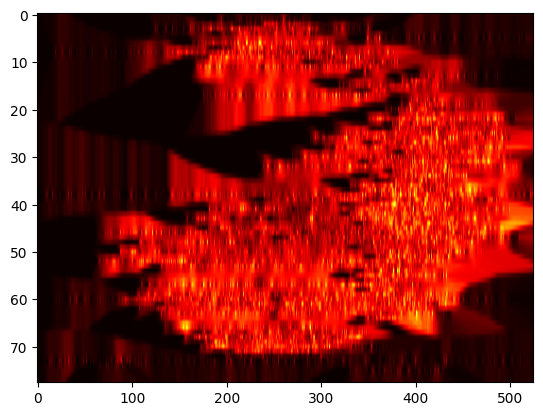

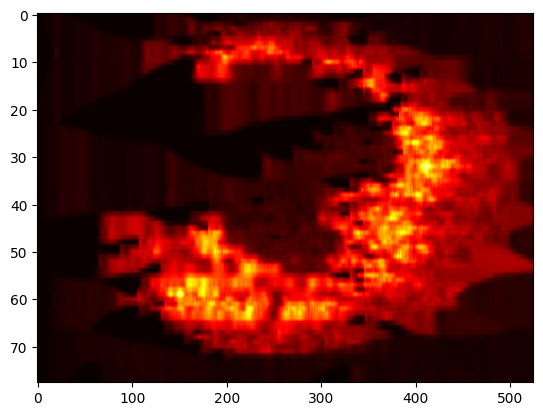

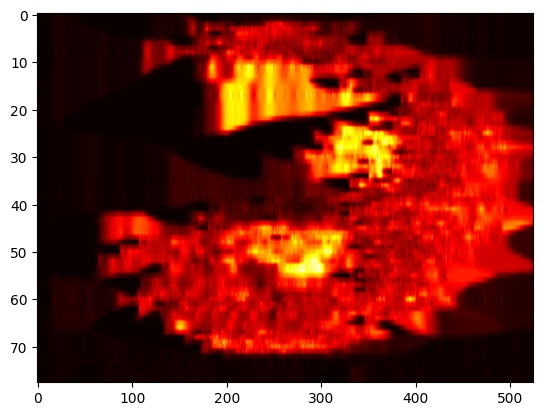

In [6]:
#==================================================================
#SAMPLE METADATA READ
#==================================================================

sampleFolders = natsort.natsorted(glob.glob('./INPUT/*'), reverse=False)

for sampleFolder in tqdm(sampleFolders, desc='Samples', leave=True, ascii=True):

    #Obtain the sample name
    name = os.path.basename(sampleFolder)

    dir_Results = '.' + os.path.sep + 'RESULTS' + os.path.sep
    if not os.path.exists(dir_Results): os.makedirs(dir_Results)

    dir_sampleResults = dir_Results + name + os.path.sep
    if os.path.exists(dir_sampleResults): shutil.rmtree(dir_sampleResults)
    os.makedirs(dir_sampleResults)

    #Read in data from sampleInfo.txt
    lineIndex = 0
    sampleInfo = open(sampleFolder+os.path.sep+'sampleInfo.txt').readlines()

    #Read the max number of lines that are expected 
    numLines = int(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read the sample width
    sampleWidth = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read the sample height
    sampleHeight = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read in scan rate
    scanRate = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read in acquistion rate
    acqRate = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read in monoisotopic mz (-1 will indicate None)
    mzMonoValue = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read window tolerance (ppm)
    ppm = float(sampleInfo[lineIndex].rstrip())*1e-6
    lineIndex += 1

    #Number of decimals for mz precision
    mzResOrder = int(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Check if files are numbered sequentially, or according to physical position
    fileNumbering = int(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Process the read information as needed for regular use cases
    ppmPos, ppmNeg = 1+ppm, 1-ppm
    mzMonoRange = [mzMonoValue*ppmNeg, mzMonoValue*ppmPos]
    if fileNumbering==0: unorderedNames = False
    elif fileNumbering==1: unorderedNames = True
    else: sys.exit('Error - File Numbering parameter used in sampleInfo is not an acceptable value.')

    #Load the sampled mask; must match final sample dimensionality
    measuredMask = np.loadtxt(sampleFolder+os.path.sep+'measuredMask.csv', 'int', delimiter=',') 

    #If the filenames were sequentially generated, then load location mapping dictionary
    physicalLineNums = {}
    if unorderedNames: 
        for item in np.loadtxt(sampleFolder+os.path.sep+'physicalLineNums.csv', 'int', delimiter=','):
            physicalLineNums[item[0]] = item[1]
            
    #Get mz ranges to use for visualizations
    try: mzValues = np.loadtxt(sampleFolder+os.path.sep+'mz.csv', delimiter=',')
    except: mzValues = np.loadtxt('mz.csv', delimiter=',')
    mzRanges = np.round(np.column_stack((mzValues*ppmNeg, mzValues*ppmPos)), mzResOrder)

    #Store final dimensions for physical domain, determining the number of columns for row-alignment interpolations
    finalDim = [numLines, int(round(((sampleWidth*1e3)/scanRate)*acqRate))]

    #Determine image dimensions that will produce square pixels (consistent vertical/horizontal resolution)
    if(finalDim[1]/sampleWidth) > (finalDim[0]/sampleHeight): 
        squareDim = [int(round((finalDim[1]*sampleHeight)/sampleWidth)), finalDim[1]]
    elif (finalDim[1]/sampleWidth) < (finalDim[0]/sampleHeight):
        squareDim = [finalDim[0], int(round((finalDim[0]*sampleWidth)/sampleHeight))]
    else:
        squareDim = finalDim

    #Get MSI extension and check for missing lines if applicable
    extensions = list(map(lambda x:x, np.unique([filename.split('.')[-1] for filename in natsort.natsorted(glob.glob(sampleFolder+os.path.sep+'*'), reverse=False)])))
    if 'd' in extensions: lineExt = '.d'
    elif 'D' in extensions: lineExt = '.D'
    elif 'raw' in extensions: lineExt = '.raw'
    elif 'RAW' in extensions: lineExt = '.RAW'
    else: sys.exit('Error! - Either no MSI files are present, or an unknown MSI filetype being used for sample: ' + name)

    #Get MSI file listing
    scanFiles = natsort.natsorted(glob.glob(sampleFolder+os.path.sep+'*'+lineExt), reverse=False)

    #Create holding arrays for the TIC, monoisotopic m/z, and mz images
    TIC = np.zeros((finalDim))
    mzMono = np.zeros((finalDim))
    mzImages = np.asarray([np.zeros((finalDim)) for mzNum in range(0, len(mzRanges))])

    #Establish new times to realign row data to
    newTimes = np.linspace(0, ((sampleWidth*1e3)/scanRate)/60, finalDim[1])

    #Read in the MSI data
    for scanFileName in tqdm(scanFiles, desc='Loading Files', leave=True, ascii=True):

        #Add a flag to indicate 'good'/'bad' data file (primarily checking for files without data)
        readErrorFlag = False

        #Establish file pointer and line number (1 indexed) for the specific scan
        try: data = mzFile(scanFileName)
        except: readErrorFlag = True
            
        #If the data file is 'good' then continue processing
        if not readErrorFlag:

            #Determine physical line location
            lineNum = int(scanFileName.split('line-')[1].split('.')[0].lstrip('0'))
            if unorderedNames: lineNum = physicalLineNums[lineNum]
            else: lineNum-=1

            #Load the indicated MSI file
            data = mzFile(scanFileName)

            #Obtain the total ion chromatogram and extract original times
            ticData = np.asarray(data.xic(data.time_range()[0], data.time_range()[1]))
            origTimes, TICData = ticData[:,0], ticData[:,1]

            #If the data was sparesly acquried, then the listed times in the file need to be shifted
            if impOffset: origTimes+= (np.argwhere(measuredMask[lineNum]==1).min()/finalDim[1])*(((sampleWidth*1e3)/scanRate)/60)

            #If normalizing by monoisotopic m/z, then obtain the relevant data
            if mzMonoValue != -1: mzMonoData = np.asarray(data.xic(data.time_range()[0], data.time_range()[1], mzMonoRange[0], mzMonoRange[1]))[:,1]

            #Read in specified mz ranges, normalize as specified, and interpolate to new times
            for mzRangeNum in range(0, len(mzRanges)): 
                mzData = np.asarray(data.xic(data.time_range()[0], data.time_range()[1], mzRanges[mzRangeNum][0], mzRanges[mzRangeNum][1]))[:,1]
                if mzMonoValue == -1: mzData = np.nan_to_num(mzData/TICData, nan=0, posinf=0, neginf=0)
                else: mzData = np.nan_to_num(mzData/mzMonoData, nan=0, posinf=0, neginf=0)
                mzImages[mzRangeNum, lineNum, :] = np.interp(newTimes, origTimes, np.nan_to_num(mzData, nan=0, posinf=0, neginf=0), left=0, right=0)

            TIC[lineNum] = np.interp(newTimes, origTimes, TICData) 
            if mzMonoValue != -1: mzMono[lineNum] = np.interp(newTimes, origTimes, mzMonoData)

    #Isolate MSI data to only the measured information
    TIC = measuredMask*TIC
    if mzMonoValue == -1: mzMono = measuredMask*mzMono
    mzImages = measuredMask*mzImages
    mzAvgImage = np.mean(mzImages,axis=0)
    
    #Resize and extract measured and unmeasured locations for the square pixel mask
    squareMask = resize(measuredMask==1, tuple(squareDim), order=0)
    squareMeasuredIdxs, squareUnMeasuredIdxs = np.transpose(np.where(squareMask==1)), np.transpose(np.where(squareMask==0))

    #Determine neighbor information for unmeasured locations
    neighborIndices, neighborWeights, neighborDistances = findNeighbors(squareMeasuredIdxs, squareUnMeasuredIdxs)

    #Resize images to square dimensionality
    squareTIC = resize(TIC, tuple(squareDim), order=0)
    if mzMonoValue != -1: squareMono = resize(mzMono, tuple(squareDim), order=0)
    squaremzAvgImage = resize(mzAvgImage, tuple(squareDim), order=0)
    squaremzImages = np.moveaxis(resize(np.moveaxis(mzImages, 0, -1), tuple(squareDim), order=0), -1, 0)

    #Compute reconstructions for all images
    squareTICReconImage = computeRecon(squareTIC, squareMeasuredIdxs, squareUnMeasuredIdxs, neighborIndices, neighborWeights)
    if mzMonoValue != -1: squareMonoReconImage = computeRecon(squareMono, squareMeasuredIdxs, squareUnMeasuredIdxs, neighborIndices, neighborWeights)
    squaremzAvgReconImage = computeRecon(squaremzAvgImage, squareMeasuredIdxs, squareUnMeasuredIdxs, neighborIndices, neighborWeights)
    squaremzReconImages = computeRecon(squaremzImages, squareMeasuredIdxs, squareUnMeasuredIdxs, neighborIndices, neighborWeights)

    #Resize reconstructions back to original dimensions
    reconTICImage = resize(squareTICReconImage, tuple(finalDim), order=0)
    if mzMonoValue != -1: monoReconImage = resize(squareMonoReconImage, tuple(finalDim), order=0)
    mzAvgReconImage = resize(squaremzAvgReconImage, tuple(finalDim), order=0)
    mzReconImages = np.moveaxis(resize(np.moveaxis(squaremzReconImages , 0, -1), tuple(finalDim), order=0), -1, 0)        

    #Plot and save measured data
    plt.imshow(measuredMask, aspect='auto', cmap='gray')
    plt.savefig(dir_sampleResults+'measured_Mask.png')
    plt.show()
    plt.close()

    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    plt.axis('off')
    plt.imshow(measuredMask, aspect='auto', cmap='gray')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(dir_sampleResults+'measured_Mask_noAxes.png', bbox_inches=extent)
    plt.close()
    
    plt.imshow(TIC, aspect='auto', cmap='hot')
    plt.savefig(dir_sampleResults+'measured_TIC.png')
    plt.show()
    plt.close()
    
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    plt.axis('off')
    plt.imshow(TIC, aspect='auto', cmap='hot')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(dir_sampleResults+'measured_TIC_noAxes.png', bbox_inches=extent)
    plt.close()

    if mzMonoValue != -1:
        plt.imshow(mzMono, aspect='auto', cmap='hot')
        plt.savefig(dir_sampleResults+'measured_mzMono-'+str(mzMonoValue)+'.png')
        plt.show()
        plt.close()
        
        fig=plt.figure()
        ax=fig.add_subplot(1,1,1)
        plt.axis('off')
        plt.imshow(mzMono, aspect='auto', cmap='hot')
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        plt.savefig(dir_sampleResults+'measured_mzMono-'+str(mzMonoValue)+'_noAxes.png', bbox_inches=extent)
        plt.close()

    plt.imshow(mzAvgImage, aspect='auto', cmap='hot')
    plt.savefig(dir_sampleResults+'measured_mzAvg.png')
    plt.show()
    plt.close()
    
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    plt.axis('off')
    plt.imshow(mzAvgImage, aspect='auto', cmap='hot')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(dir_sampleResults+'measured_mzAvg_noAxes.png', bbox_inches=extent)
    plt.close()

    for mzNum in range(0, len(mzValues)):
        plt.imshow(mzImages[mzNum,:,:], aspect='auto', cmap='hot')
        plt.savefig(dir_sampleResults+'measured_mz-'+str(mzValues[mzNum])+'.png')
        plt.show()
        plt.close()
        
        fig=plt.figure()
        ax=fig.add_subplot(1,1,1)
        plt.axis('off')
        plt.imshow(mzImages[mzNum,:,:], aspect='auto', cmap='hot')
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        plt.savefig(dir_sampleResults+'measured_mz-'+str(mzValues[mzNum])+'_noAxes.png', bbox_inches=extent)
        plt.close()

    #Plot and save reconstructions of data
    plt.imshow(reconTICImage, aspect='auto', cmap='hot')
    plt.savefig(dir_sampleResults+'recon_TIC.png')
    plt.show()
    plt.close()
    
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    plt.axis('off')
    plt.imshow(reconTICImage, aspect='auto', cmap='hot')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(dir_sampleResults+'recon_TIC_noAxes.png', bbox_inches=extent)
    plt.close()

    if mzMonoValue != -1:
        plt.imshow(monoReconImage, aspect='auto', cmap='hot')
        plt.savefig(dir_sampleResults+'recon_mzMono-'+str(mzMonoValue)+'.png')
        plt.show()
        plt.close()
        
        fig=plt.figure()
        ax=fig.add_subplot(1,1,1)
        plt.axis('off')
        plt.imshow(monoReconImage, aspect='auto', cmap='hot')
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        plt.savefig(dir_sampleResults+'recon_mzMono-'+str(mzMonoValue)+'_noAxes.png', bbox_inches=extent)
        plt.close()

    plt.imshow(mzAvgReconImage, aspect='auto', cmap='hot')
    plt.savefig(dir_sampleResults+'recon_mzAvg.png')
    plt.show()
    plt.close()
    
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    plt.axis('off')
    plt.imshow(mzAvgReconImage, aspect='auto', cmap='hot')
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    plt.savefig(dir_sampleResults+'recon_mzAvg_noAxes.png', bbox_inches=extent)
    plt.close()

    for mzNum in range(0, len(mzValues)):
        plt.imshow(mzReconImages[mzNum,:,:], aspect='auto', cmap='hot')
        plt.savefig(dir_sampleResults+'mzRecon-'+str(mzValues[mzNum])+'.png')
        plt.show()
        plt.close()
        
        fig=plt.figure()
        ax=fig.add_subplot(1,1,1)
        plt.axis('off')
        plt.imshow(mzReconImages[mzNum,:,:], aspect='auto', cmap='hot')
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        plt.savefig(dir_sampleResults+'mzRecon-'+str(mzValues[mzNum])+'_noAxes.png', bbox_inches=extent)
        plt.close()

    
#==================================================================

In [ ]:
##Reconstruction with padded sample exterior as measured zeros
##Could potentially decrease the amount of stretching to the edges

##Resize and extract measured and unmeasured locations for the square pixel mask
#squareMask = resize(measuredMask==1, tuple(squareDim), order=0)
#squareMask = np.pad(squareMask, (1, 1), mode='constant',constant_values=1)
#squareMeasuredIdxs, squareUnMeasuredIdxs = np.transpose(np.where(squareMask==1)), np.transpose(np.where(squareMask==0))

##Determine neighbor information for unmeasured locations
#neighborIndices, neighborWeights, neighborDistances = findNeighbors(squareMeasuredIdxs, squareUnMeasuredIdxs)

##Resize images to square dimensionality and pad border with zeros
#squareTIC = np.pad(resize(TIC, tuple(squareDim), order=0), (1, 1), mode='constant',constant_values=0)
#squaremzAvgImage = np.pad(resize(mzAvgImage, tuple(squareDim), order=0), (1, 1), mode='constant',constant_values=0)
#squaremzImages = np.asarray([np.pad(mzImage, (1, 1), mode='constant',constant_values=0) for mzImage in np.moveaxis(resize(np.moveaxis(mzImages, 0, -1), tuple(squareDim), order=0), -1, 0)])

##Compute reconstructions for all images
#squareTICReconImage = computeRecon(squareTIC, squareMeasuredIdxs, squareUnMeasuredIdxs, neighborIndices, neighborWeights)
#squaremzAvgReconImage = computeRecon(squaremzAvgImage, squareMeasuredIdxs, squareUnMeasuredIdxs, neighborIndices, neighborWeights)
#squaremzReconImages = computeRecon(squaremzImages, squareMeasuredIdxs, squareUnMeasuredIdxs, neighborIndices, neighborWeights)

##Resize reconstructions back to original dimensions
#TICReconImage = resize(squareTICReconImage, tuple(finalDim), order=0)
#mzAvgReconImage = resize(squaremzAvgReconImage, tuple(finalDim), order=0)
#mzReconImages = np.moveaxis(resize(np.moveaxis(squaremzReconImages , 0, -1), tuple(finalDim), order=0), -1, 0)        
